In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS3540/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CS3540-Assignments', 'CS3540-CodeSessions', 'prisondata.csv', 'prisondata.gsheet', 'Prison-Ashley.ipynb', 'unemployment.csv', 'crime_and_incarceration_by_state.csv', 'crime_and_incarceration_by_state.gsheet', 'unemployment.gsheet', 'Untitled0.ipynb', 'CS3540-Final-Project-G12']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# import needed libraries
from __future__ import absolute_import, division, print_function, unicode_literals

# import libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
# Helper libraries

print(tf.__version__)

2.19.0


In [4]:
data_path = GOOGLE_DRIVE_PATH + '/CS3540-Final-Project-G12/New Attempt Dataset Options'
print(os.listdir(data_path))

['US CPI.csv', 'US_inflation_rates.csv', 'df_unemployment_rates.csv', 'df_sex_unemployment_rates.csv', '2015-2025.csv', 'unemployment.csv', 'gold_monthly_csv.csv', 'gold_annual_csv.csv', 'avocado.csv', 'globalEconomicDataset.zip', 'foodPrices.zip', 'EconomnicData.zip', 'combined_unemployment.csv', 'economic_data.gsheet', 'oil_and_housing.csv']


# Combining Data
To start, I will combine all the unemployment data

In [5]:
unemployment_sex_df = pd.read_csv(data_path + '/df_sex_unemployment_rates.csv')
unemployment_age_df = pd.read_csv(data_path + '/df_unemployment_rates.csv')
combined_unemployment = pd.concat([unemployment_age_df, unemployment_sex_df], axis=1)

print(combined_unemployment)

           date  overall_rate  age_16_17_rate  age_16_19_rate  age_18_19_rate  \
0    1948-01-01           3.4             9.4             8.5             8.3   
1    1948-02-01           3.8            13.1            10.0             8.2   
2    1948-03-01           4.0            13.0            10.5             8.9   
3    1948-04-01           3.9            11.2             9.5             8.6   
4    1948-05-01           3.5             6.5             7.0             7.9   
..          ...           ...             ...             ...             ...   
912  2024-01-01           3.7            10.0            10.6            10.8   
913  2024-02-01           3.9            12.5            12.5            12.2   
914  2024-03-01           3.8            14.1            12.6            11.5   
915  2024-04-01           3.9            12.6            11.7            11.3   
916  2024-05-01           4.0            13.6            12.3            11.4   

     age_16_24_rate  age_20

# Input Data Clean-up
Getting rid of the few rows with NAN values, and duplicate date columns. We will also filter the data so that it is in between the specific dates of the output data

In [6]:
cleaned_combined_data = combined_unemployment.dropna(axis=1, how='any')

# Drop only the columns at indexes 14 and 15
cols_to_keep = [i for i in range(cleaned_combined_data.shape[1]) if i not in [14, 15]]
final_data = cleaned_combined_data.iloc[:, cols_to_keep]

print(final_data.columns)
final_data = final_data[final_data["date"].between("1948-01-01", "2021-07-01")]
print(final_data.head)

Index(['date', 'overall_rate', 'age_16_17_rate', 'age_16_19_rate',
       'age_18_19_rate', 'age_16_24_rate', 'age_20_24_rate', 'age_25_34_rate',
       'age_25_54_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_20plus_rate',
       'age_25plus_rate', 'age_55plus_rate', 'men_rate', 'women_rate',
       'men_16_17_rate', 'women_16_17_rate', 'men_16_19_rate',
       'women_16_19_rate', 'men_18_19_rate', 'women_18_19_rate',
       'men_16_24_rate', 'women_16_24_rate', 'men_20_24_rate',
       'women_20_24_rate', 'men_25plus_rate', 'women_25plus_rate',
       'men_25_34_rate', 'women_25_34_rate', 'men_25_54_rate',
       'women_25_54_rate', 'men_35_44_rate', 'women_35_44_rate',
       'men_45_54_rate', 'women_45_54_rate', 'men_55plus_rate'],
      dtype='object')
<bound method NDFrame.head of            date  overall_rate  age_16_17_rate  age_16_19_rate  age_18_19_rate  \
0    1948-01-01           3.4             9.4             8.5             8.3   
1    1948-02-01           3.8         

# Adding on the CPI
To finalize our input data, we will now use the combined unemployment rate data to the CPI, which should boost our ability to predict. Because the Inflation value is calculated from the CPI, I'll use the lagged CPI values, specifically the past year by that month's CPI Value.


The Consumer Price Index (CPI) is a weighted index that measures the changes in price for a basket of household consumer goods and services.
‍
The basket constituents are reviewed and amended annually to account for any changes in consumer behaviour or spending.
‍
Considered as a lens through which the health of an economy can be viewed, CPI is a key tool for central banks in making decisions relating to monetary policy.

https://equalsmoney.com/financial-glossary/consumer-price-index#:~:text=The%20CPI%20is%20a%20key%20tool%20for,patterns%2C%20and%20economic%20conditions%20across%20different%20areas.

In [7]:
cpi_data = pd.read_csv(data_path + "/US CPI.csv")
# Convert "Yearmon" to datetime
cpi_data["Yearmon"] = pd.to_datetime(cpi_data["Yearmon"], format="%d-%m-%Y")
final_data["date"] = pd.to_datetime(final_data["date"])

# Now safely filter by date
cleaned_cpi_data = cpi_data[cpi_data["Yearmon"].between("1947-01-01", "2020-07-01")]

# Increase each year by one, cuz now this will be the past year
cleaned_cpi_data["date plus one"] = cleaned_cpi_data["Yearmon"] + pd.DateOffset(years=1)



# Merge on date columns
input_data = pd.merge( final_data, cleaned_cpi_data, how="inner", left_on="date",
                      right_on="date plus one")
# Drop duplicate date column from CPI
input_data = input_data.drop(columns=["Yearmon", "date plus one"])

# check one more time for NAN values
input_data = input_data.dropna(axis=1, how="any")
print(input_data.head)



<bound method NDFrame.head of           date  overall_rate  age_16_17_rate  age_16_19_rate  age_18_19_rate  \
0   1948-01-01           3.4             9.4             8.5             8.3   
1   1948-02-01           3.8            13.1            10.0             8.2   
2   1948-03-01           4.0            13.0            10.5             8.9   
3   1948-04-01           3.9            11.2             9.5             8.6   
4   1948-05-01           3.5             6.5             7.0             7.9   
..         ...           ...             ...             ...             ...   
878 2021-03-01           6.1            12.4            13.0            13.2   
879 2021-04-01           6.1            11.0            12.0            12.9   
880 2021-05-01           5.8             9.1             9.7            10.1   
881 2021-06-01           5.9            11.3            11.1            10.5   
882 2021-07-01           5.4            11.2            10.4             9.8   

     age_

/tmp/ipython-input-3139188151.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_cpi_data["date plus one"] = cleaned_cpi_data["Yearmon"] + pd.DateOffset(years=1)


# Output Data
Now that the input data is organized, now for the output data that we are trying to predict

In [8]:
inflation_rate = pd.read_csv(data_path + "/US_inflation_rates.csv")
output_data = inflation_rate[inflation_rate["date"].between("1948-01-01", "2021-07-01")]
print(output_data)

           date    value
12   1948-01-01   23.680
13   1948-02-01   23.670
14   1948-03-01   23.500
15   1948-04-01   23.820
16   1948-05-01   24.010
..          ...      ...
890  2021-03-01  264.914
891  2021-04-01  266.670
892  2021-05-01  268.444
893  2021-06-01  270.559
894  2021-07-01  271.764

[883 rows x 2 columns]


# Visualization

Now I want to visualize the data. This will be a series of graphs to determine the best ML algorithm for the job

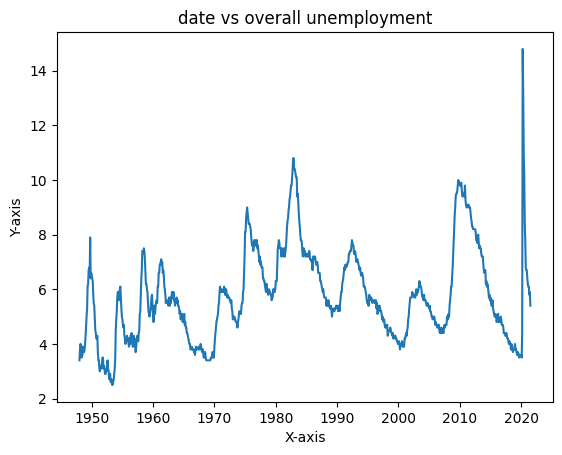

In [9]:
plt.plot(input_data["date"], input_data["overall_rate"])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('date vs overall unemployment')

plt.show()

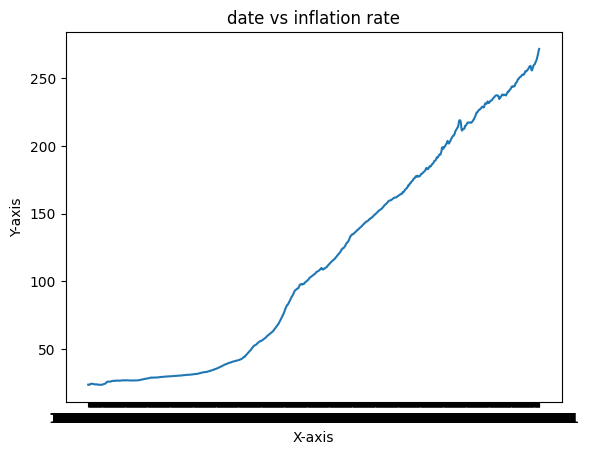

In [10]:
plt.plot(output_data["date"], output_data["value"])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('date vs inflation rate')

plt.show()

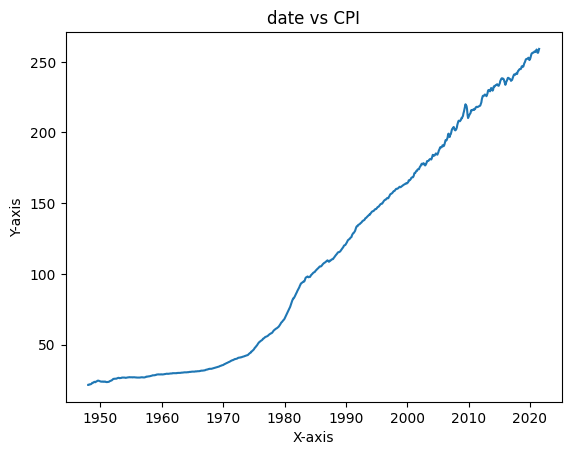

In [11]:
plt.plot(input_data["date"], input_data["CPI"])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('date vs CPI')

plt.show()

# Column Names

I want to see all of the column names of the data we are working with

In [12]:
print(input_data.columns)
print(input_data.shape)
print(output_data.shape)

Index(['date', 'overall_rate', 'age_16_17_rate', 'age_16_19_rate',
       'age_18_19_rate', 'age_16_24_rate', 'age_20_24_rate', 'age_25_34_rate',
       'age_25_54_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_20plus_rate',
       'age_25plus_rate', 'age_55plus_rate', 'men_rate', 'women_rate',
       'men_16_17_rate', 'women_16_17_rate', 'men_16_19_rate',
       'women_16_19_rate', 'men_18_19_rate', 'women_18_19_rate',
       'men_16_24_rate', 'women_16_24_rate', 'men_20_24_rate',
       'women_20_24_rate', 'men_25plus_rate', 'women_25plus_rate',
       'men_25_34_rate', 'women_25_34_rate', 'men_25_54_rate',
       'women_25_54_rate', 'men_35_44_rate', 'women_35_44_rate',
       'men_45_54_rate', 'women_45_54_rate', 'men_55plus_rate', 'CPI'],
      dtype='object')
(883, 38)
(883, 2)


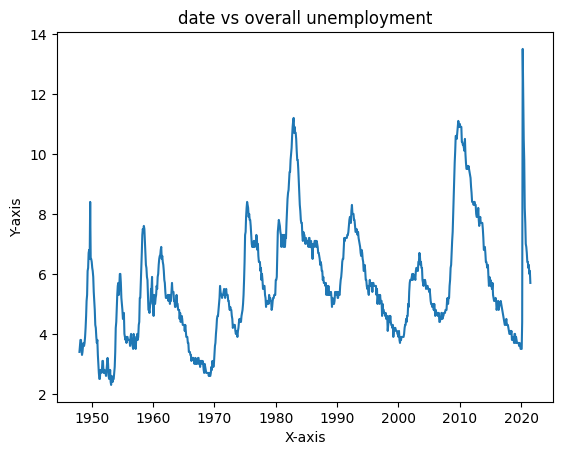

In [13]:
plt.plot(input_data["date"], input_data["men_rate"])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('date vs overall unemployment')

plt.show()

# Ridge Regression
First I will try ridge regression to see if unemployment makes a difference in predictions

In [14]:
input_data["ones"] = 1

X = input_data.iloc[:, [38] + list(range(1, 38))]
# dropping the ones column now because i only need it for the ridge regression
input_data = input_data.drop(columns=["ones"], axis=1)
print(X.head)
Y = output_data.iloc[:, [1]]
print(Y.head)

<bound method NDFrame.head of      ones  overall_rate  age_16_17_rate  age_16_19_rate  age_18_19_rate  \
0       1           3.4             9.4             8.5             8.3   
1       1           3.8            13.1            10.0             8.2   
2       1           4.0            13.0            10.5             8.9   
3       1           3.9            11.2             9.5             8.6   
4       1           3.5             6.5             7.0             7.9   
..    ...           ...             ...             ...             ...   
878     1           6.1            12.4            13.0            13.2   
879     1           6.1            11.0            12.0            12.9   
880     1           5.8             9.1             9.7            10.1   
881     1           5.9            11.3            11.1            10.5   
882     1           5.4            11.2            10.4             9.8   

     age_16_24_rate  age_20_24_rate  age_25_34_rate  age_25_54_rate  

# Splitting Data
I need to split it manually since it is a time series dataset

In [15]:
train_size = int(0.8 * len(input_data))
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))
print(model.alpha)

RMSE: 3.1929978866118343
R² score: 0.9641215127952647
1.0


# Checking Feature Importance
These numbers are really great! But I am concerned that my lagged CPI data is dominating the calculation. So, I want to perform further analysis before I get into the neural network.

The average drop in model performance when that feature is randomized.

In [17]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_scaled, Y_test, n_repeats=10,
                                random_state=42)

perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_df)

              feature  importance
37                CPI    1.975961
22     men_16_24_rate    0.143951
15         women_rate    0.137394
5      age_16_24_rate    0.094399
24     men_20_24_rate    0.083905
8      age_25_54_rate    0.076460
31   women_25_54_rate    0.069517
11    age_20plus_rate    0.062964
32     men_35_44_rate    0.052528
1        overall_rate    0.040399
10     age_45_54_rate    0.040375
7      age_25_34_rate    0.035676
26    men_25plus_rate    0.031194
14           men_rate    0.027985
29   women_25_34_rate    0.027014
9      age_35_44_rate    0.026662
27  women_25plus_rate    0.019219
4      age_18_19_rate    0.014372
33   women_35_44_rate    0.011258
36    men_55plus_rate    0.009334
30     men_25_54_rate    0.008745
6      age_20_24_rate    0.008536
18     men_16_19_rate    0.006787
23   women_16_24_rate    0.003832
28     men_25_34_rate    0.003822
13    age_55plus_rate    0.003557
12    age_25plus_rate    0.003194
25   women_20_24_rate    0.003084
16     men_16_

In [18]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_[0]
}).sort_values(by="coef", key=lambda s: np.abs(s), ascending=False)

print(coef_df.head(10))

          feature  coef
0            ones   0.0
1    overall_rate   0.0
2  age_16_17_rate   0.0
3  age_16_19_rate   0.0
4  age_18_19_rate   0.0
5  age_16_24_rate   0.0
6  age_20_24_rate   0.0
7  age_25_34_rate   0.0
8  age_25_54_rate   0.0
9  age_35_44_rate   0.0


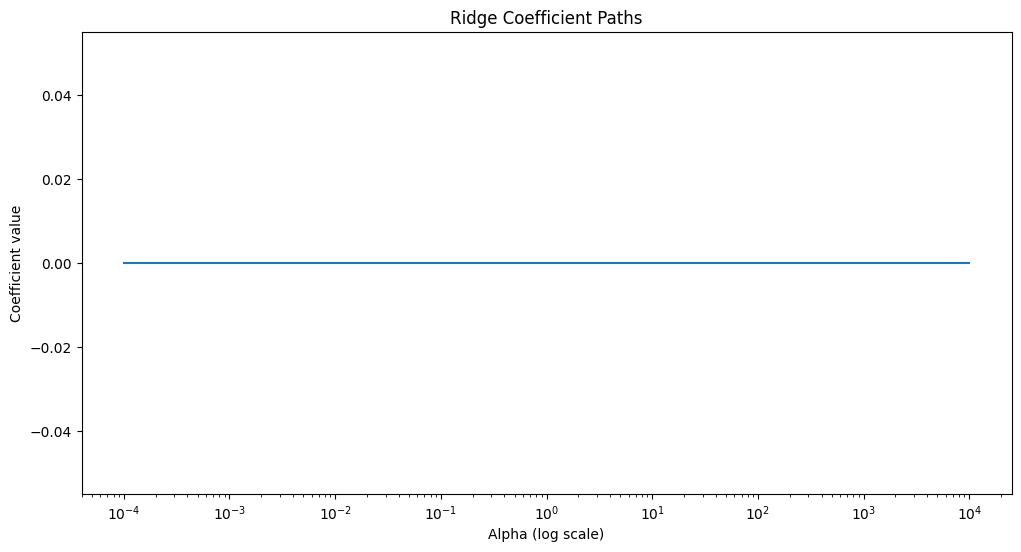

In [19]:
alphas = np.logspace(-4, 4, 50)
coefs = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, Y_train)
    coefs.append(ridge.coef_[0])

plt.figure(figsize=(12,6))
plt.plot(alphas, coefs)
plt.xscale("log")
plt.title("Ridge Coefficient Paths")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Coefficient value")
plt.show()

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                    for i in range(X_train.shape[1])]

print(vif_data)

              feature          VIF
0                ones   106.550461
1        overall_rate  1677.629029
2      age_16_17_rate  1781.503515
3      age_16_19_rate  6735.819312
4      age_18_19_rate  5114.284955
5      age_16_24_rate  4357.626437
6      age_20_24_rate  2304.630342
7      age_25_34_rate  1109.211609
8      age_25_54_rate  1504.095100
9      age_35_44_rate   776.238649
10     age_45_54_rate   601.405922
11    age_20plus_rate  1695.513699
12    age_25plus_rate  1276.377665
13    age_55plus_rate    76.897852
14           men_rate  1314.813139
15         women_rate   551.362906
16     men_16_17_rate   707.000195
17   women_16_17_rate   328.916934
18     men_16_19_rate  2437.980179
19   women_16_19_rate  1694.431799
20     men_18_19_rate  1945.403783
21   women_18_19_rate  1102.198046
22     men_16_24_rate  2350.562570
23   women_16_24_rate  1531.968714
24     men_20_24_rate  1421.730555
25   women_20_24_rate   508.817740
26    men_25plus_rate  1152.831612
27  women_25plus_rat

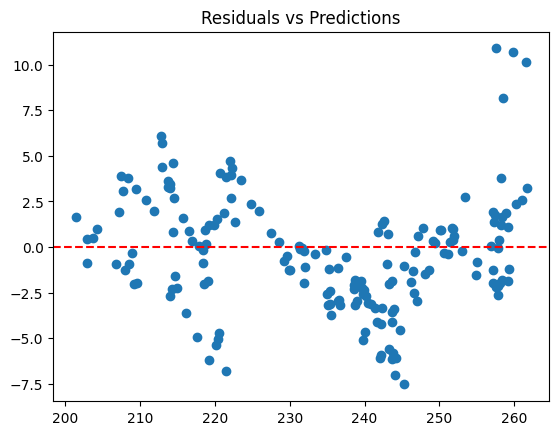

In [21]:
residuals = Y_test.values.flatten() - Y_pred.flatten()

plt.scatter(Y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions")
plt.show()

In [22]:
from sklearn.linear_model import LinearRegression, Lasso

models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

for name, m in models.items():
    m.fit(X_train_scaled, Y_train)
    pred = m.predict(X_test_scaled)
    print(name, "RMSE:", np.sqrt(mean_squared_error(Y_test, pred)))

OLS RMSE: 3.1827362498133507
Ridge RMSE: 3.1929978866118343
Lasso RMSE: 3.1459104681072474


In [23]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []

for train_idx, test_idx in tscv.split(X):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    Y_tr, Y_te = Y.iloc[train_idx], Y.iloc[test_idx]

    X_tr_scaled = scaler.fit_transform(X_tr)
    X_te_scaled = scaler.transform(X_te)

    model = Ridge(alpha=1.0)
    model.fit(X_tr_scaled, Y_tr)
    pred = model.predict(X_te_scaled)

    rmse_scores.append(np.sqrt(mean_squared_error(Y_te, pred)))

print(rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

[np.float64(1.6167954509094713), np.float64(4.426388901248743), np.float64(1.4563398372920044), np.float64(2.01870704287204), np.float64(3.5267407020653248)]
Average RMSE: 2.6089943868775167


# Analysis
The analysis shows that yes, CPI does dominate. My unemployment data doesn't seem to be adding really anything to the predictions. Therefore, I am going to try and add more relevant data that will hopefully help in predictions.

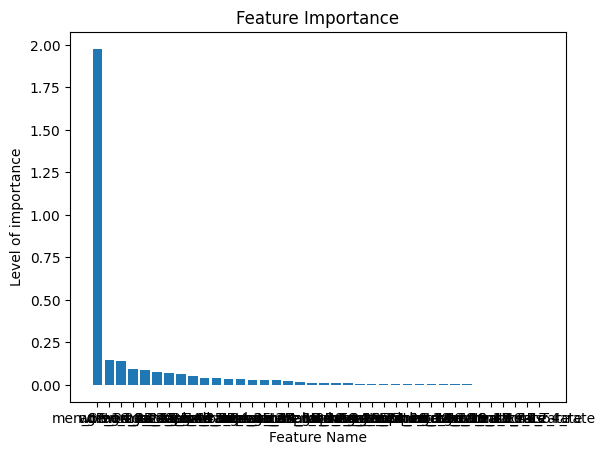

In [24]:
plt.bar(perm_df["feature"], perm_df["importance"])
plt.title("Feature Importance")
plt.xlabel("Feature Name")
plt.ylabel("Level of importance")

plt.show()


# Experiment
To experiment, I am going to analyze the model's accuracy without the CPI

In [25]:
no_cpi = input_data.drop(columns=["CPI", "date"], axis=1)
no_cpi_train = no_cpi.iloc[:train_size]
no_cpi_test = no_cpi.iloc[train_size:]

no_cpi_train_scaled = scaler.fit_transform(no_cpi_train)
no_cpi_test_scaled  = scaler.transform(no_cpi_test)

model = Ridge(alpha=1.0)
model.fit(no_cpi_train_scaled, Y_train)

Y_pred = model.predict(no_cpi_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))

result = permutation_importance(model, no_cpi_test_scaled, Y_test, n_repeats=10,
                                random_state=42)

perm_df = pd.DataFrame({
    'feature': no_cpi_train.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_df)

RMSE: 61.227525643141945
R² score: -12.192596468101273
              feature  importance
14         women_rate  197.292194
4      age_16_24_rate  102.289298
6      age_25_34_rate   86.696166
8      age_35_44_rate   57.824844
29     men_25_54_rate   51.754833
25    men_25plus_rate   51.646835
21     men_16_24_rate   46.213847
24   women_20_24_rate   30.318438
26  women_25plus_rate   30.201967
28   women_25_34_rate   21.014153
23     men_20_24_rate   20.075239
18   women_16_19_rate   19.198714
1      age_16_17_rate   15.562256
10    age_20plus_rate   13.684262
32   women_35_44_rate   12.479667
22   women_16_24_rate   11.686620
0        overall_rate   11.177761
15     men_16_17_rate    9.704344
31     men_35_44_rate    7.624010
13           men_rate    6.419341
9      age_45_54_rate    4.505548
35    men_55plus_rate    3.239342
5      age_20_24_rate    3.153410
27     men_25_34_rate    2.563046
11    age_25plus_rate    2.317850
7      age_25_54_rate    2.104607
33     men_45_54_rate    0.

# Improving data
After this experiment, it is clear that unemployment does not add much of anything to my predictions. Some of the features did seem to add some power but not really anything when you took out the CPI. Which leads to me figuring that I need some different data to go along with CPI that will more effectively spread out the weight of what predicts the actual inflation value. Here is some data that I am going to add:

- Crude oil prices - 1950 - 2025 https://www.macrotrends.net/1369/crude-oil-price-history-chart
- median sales price of homes in US - 1963 - 2025 https://fred.stlouisfed.org/series/MSPUS

Because of the change in dates, I am going to have to decrease the rows in my dataset to get more colummns/features. I have made a modified dataset with this information combined in the right date format that I will now combine with the CPI data, along with the few most impactful unemployment features.

In [26]:
# Here I am going to do PCA on my previous ridge regression model and see which unemployment features matter most
# Extract unemployment subset
unemp_data = no_cpi.copy()

# Standardize
scaler = StandardScaler()
unemp_scaled = scaler.fit_transform(unemp_data)

pca = PCA(n_components=0.95)   # keep components that explain 95% variance
unemp_pca = pca.fit_transform(unemp_scaled)

print(f"Number of PCA components kept: {pca.n_components_}")
print("Explained variance ratio:", pca.explained_variance_ratio_)


Number of PCA components kept: 3
Explained variance ratio: [0.86778275 0.0559421  0.03571053]


In [27]:
# Convert back to dataframe with readable names
pca_cols = [f"unemp_pca_{i+1}" for i in range(pca.n_components_)]
unemp_pca_df = pd.DataFrame(unemp_pca, columns=pca_cols, index=input_data.index)

# Remove original unemployment columns
input_data_reduced = input_data[["date", "CPI"]]

# Add PCA components
input_data_reduced = pd.concat([input_data_reduced, unemp_pca_df], axis=1)

input_data_reduced.head()

,date,CPI,unemp_pca_1,unemp_pca_2,unemp_pca_3
0,1948-01-01,21.5,-9.047716,-2.126126,-0.849506
1,1948-02-01,21.5,-6.999779,-1.529045,-0.027891
2,1948-03-01,21.9,-6.787119,-1.272379,-0.611524
3,1948-04-01,21.9,-6.984102,-1.820168,0.007264
4,1948-05-01,21.9,-8.767259,-3.280350,0.056908


In [29]:
oil_and_housing_df = pd.read_csv(data_path + '/oil_and_housing.csv')
input_data_reduced = input_data_reduced[input_data_reduced["date"].between("1963-01-01", "2021-07-01")]

cols_1 = oil_and_housing_df[["date", "crude oil price", "MSPUS"]]
cols_2 = input_data_reduced[["date","CPI", "unemp_pca_1", "unemp_pca_2", "unemp_pca_3"]]
cols_1["date"] = pd.to_datetime(cols_1["date"])
cols_2["date"] = pd.to_datetime(cols_2["date"])
new_input_data = pd.merge(cols_1, cols_2, how="inner", on="date")
print(new_input_data)

# Making output dates equivalent
output_data = output_data[output_data["date"].between("1963-01-01", "2021-07-01")]

          date  crude oil price   MSPUS      CPI  unemp_pca_1  unemp_pca_2  \
0   1963-01-01             2.97   17800   30.000     0.120313    -0.584489   
1   1963-02-01             2.97   17800   30.100     1.194740     0.677182   
2   1963-03-01             2.97   17800   30.100     0.362443     0.432217   
3   1963-04-01             2.97   18000   30.200     0.145076     0.309797   
4   1963-05-01             2.97   18000   30.200     1.138073     1.235519   
..         ...              ...     ...      ...          ...          ...   
698 2021-03-01            59.19  106000  258.115     0.514525    -3.443293   
699 2021-04-01            63.50  106000  256.389     0.425252    -3.992617   
700 2021-05-01            66.31  106000  256.394    -1.281631    -4.977594   
701 2021-06-01            73.52  106000  257.797    -0.504337    -4.410046   
702 2021-07-01            73.93  106000  259.101    -2.093624    -3.938755   

     unemp_pca_3  
0       1.022388  
1       0.268840  
2     

# New Ridge Regression

Now I am going to do a new ridge regression model on this new input data, and see the weight each of these features has on the output

In [30]:
# Splitting data
train_size = int(0.8 * len(new_input_data))
X = new_input_data.drop(columns=["date"])
Y = output_data.iloc[:, [1]]
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]

# scaling and doing ridge regression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))

RMSE: 4.622662098282222
R² score: 0.8844290090340586


           feature    importance
2              CPI  1.955802e+00
3      unemp_pca_1  2.128132e-02
5      unemp_pca_3  9.742518e-03
0  crude oil price  6.967925e-03
1            MSPUS -1.110223e-16
4      unemp_pca_2 -2.005864e-02


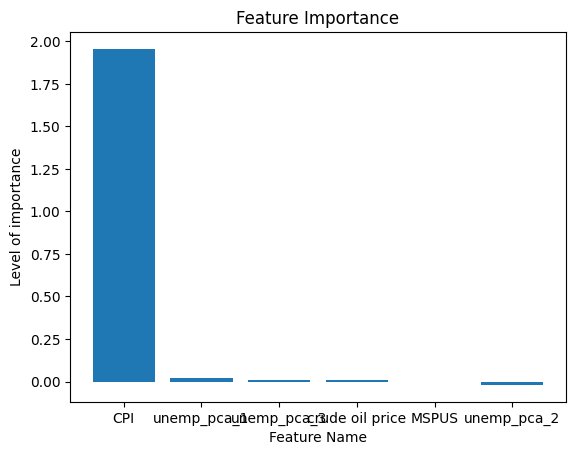

In [31]:
result = permutation_importance(model, X_test_scaled, Y_test, n_repeats=10,
                                random_state=42)

perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_df)
plt.bar(perm_df["feature"], perm_df["importance"])
plt.title("Feature Importance")
plt.xlabel("Feature Name")
plt.ylabel("Level of importance")

plt.show()


## Adding lags helps Ridge Regression because:
- Economic effects are delayed
- Time-series have momentum that lags capture
- Ridge handles many correlated predictors well
- Lags encode trend shape and velocity
- It improves predictive accuracy significantly

In [32]:
print(new_input_data.shape)
print(output_data.shape)

new_input_data["date"] = pd.to_datetime(new_input_data["date"])
output_data["date"] = pd.to_datetime(output_data["date"])

# 1. Lag your feature set (input only)
def add_lags(df, cols, num_lags):
    df = df.copy()
    for col in cols:
        for lag in range(1, num_lags+1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

feature_cols = ["crude oil price", "MSPUS", "CPI",
                "unemp_pca_1", "unemp_pca_2", "unemp_pca_3"]

lagged_input = add_lags(new_input_data, feature_cols, 3)

# 2. Merge lagged input with output data ON DATE
combined = pd.merge(lagged_input, output_data, on="date", how="inner")

# 3. Drop NaNs ONLY AFTER merging
combined = combined.dropna()

print(combined.shape)
combined.head()


(703, 7)
(703, 2)
(700, 26)


,date,crude oil price,MSPUS,CPI,unemp_pca_1,unemp_pca_2,unemp_pca_3,crude oil price_lag1,crude oil price_lag2,crude oil price_lag3,...,unemp_pca_1_lag1,unemp_pca_1_lag2,unemp_pca_1_lag3,unemp_pca_2_lag1,unemp_pca_2_lag2,unemp_pca_2_lag3,unemp_pca_3_lag1,unemp_pca_3_lag2,unemp_pca_3_lag3,value
3,1963-04-01,2.97,18000,30.2,0.145076,0.309797,0.274546,2.97,2.97,2.97,...,0.362443,1.194740,0.120313,0.432217,0.677182,-0.584489,0.378216,0.268840,1.022388,30.48
4,1963-05-01,2.97,18000,30.2,1.138073,1.235519,0.428665,2.97,2.97,2.97,...,0.145076,0.362443,1.194740,0.309797,0.432217,0.677182,0.274546,0.378216,0.268840,30.51
5,1963-06-01,2.97,18000,30.2,-0.000330,1.154980,0.875817,2.97,2.97,2.97,...,1.138073,0.145076,0.362443,1.235519,0.309797,0.432217,0.428665,0.274546,0.378216,30.61
6,1963-07-01,2.97,17900,30.3,0.428897,1.604951,0.783519,2.97,2.97,2.97,...,-0.000330,1.138073,0.145076,1.154980,1.235519,0.309797,0.875817,0.428665,0.274546,30.69
7,1963-08-01,2.97,17900,30.3,-0.584095,0.446848,0.991628,2.97,2.97,2.97,...,0.428897,-0.000330,1.138073,1.604951,1.154980,1.235519,0.783519,0.875817,0.428665,30.75


## New ridge regression with lags

In [33]:
# Splitting data
train_size = int(0.8 * len(new_input_data))
X = combined.drop(columns=["date", "value"])
Y = combined.iloc[:, [25]]
X_train = X.iloc[:train_size]
Y_train = Y.iloc[:train_size]

X_test = X.iloc[train_size:]
Y_test = Y.iloc[train_size:]

# scaling and doing ridge regression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, Y_train)

Y_pred = model.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, Y_pred)))
print("R² score:", r2_score(Y_test, Y_pred))

RMSE: 4.64983198283518
R² score: 0.8780993683488412


                 feature  importance
2                    CPI    0.209248
14              CPI_lag3    0.177422
12              CPI_lag1    0.176152
13              CPI_lag2    0.168116
17      unemp_pca_1_lag3    0.105415
16      unemp_pca_1_lag2    0.010261
23      unemp_pca_3_lag3    0.006949
22      unemp_pca_3_lag2    0.002513
21      unemp_pca_3_lag1    0.002246
5            unemp_pca_3    0.001889
9             MSPUS_lag1    0.000000
10            MSPUS_lag2    0.000000
11            MSPUS_lag3    0.000000
1                  MSPUS    0.000000
8   crude oil price_lag3   -0.004961
4            unemp_pca_2   -0.005831
3            unemp_pca_1   -0.006054
6   crude oil price_lag1   -0.006148
7   crude oil price_lag2   -0.006422
18      unemp_pca_2_lag1   -0.007146
0        crude oil price   -0.007811
15      unemp_pca_1_lag1   -0.007850
19      unemp_pca_2_lag2   -0.009301
20      unemp_pca_2_lag3   -0.016826


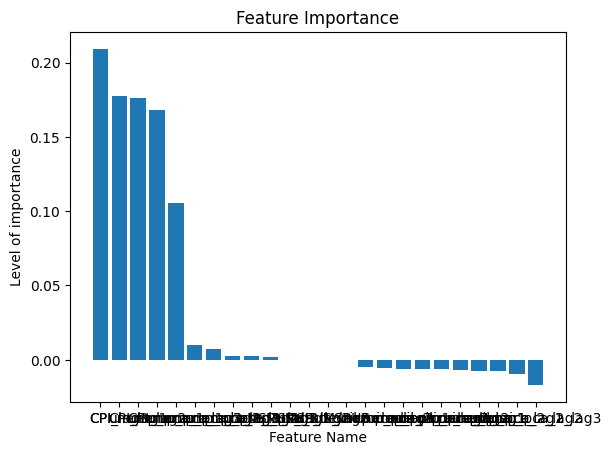

In [34]:
result = permutation_importance(model, X_test_scaled, Y_test, n_repeats=10,
                                random_state=42)

perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_df)
plt.bar(perm_df["feature"], perm_df["importance"])
plt.title("Feature Importance")
plt.xlabel("Feature Name")
plt.ylabel("Level of importance")

plt.show()

# Neural Network

Ok, so now I am going to design a neural network. No, my data is not perfect, but I want to make the model of a neural network so that I can then fill it with better data. I am also hoping that the neural network, with backpropagation will be able to leverage these features better.

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4860.0205 - mae: 58.9084 - val_loss: 37788.3555 - val_mae: 193.8899
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4622.9077 - mae: 56.1140 - val_loss: 37225.1055 - val_mae: 192.4530
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4361.2515 - mae: 52.9222 - val_loss: 36387.7695 - val_mae: 190.2894
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4026.2991 - mae: 48.4471 - val_loss: 35107.4180 - val_mae: 186.9212
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3624.5437 - mae: 42.2535 - val_loss: 33196.7344 - val_mae: 181.7607
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3210.2363 - mae: 34.7215 - val_loss: 30507.3203 - val_mae: 174.2064
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2843.2964 - mae: 33.1042 - val_loss: 26886.2520 - val_mae: 163.4222
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2487.4954 - mae: 33.6608 - val_loss: 22309.5488 - val_ma

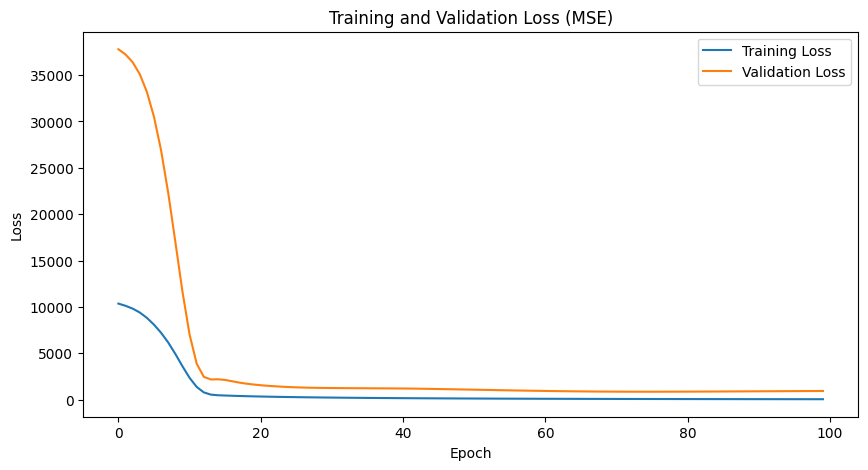

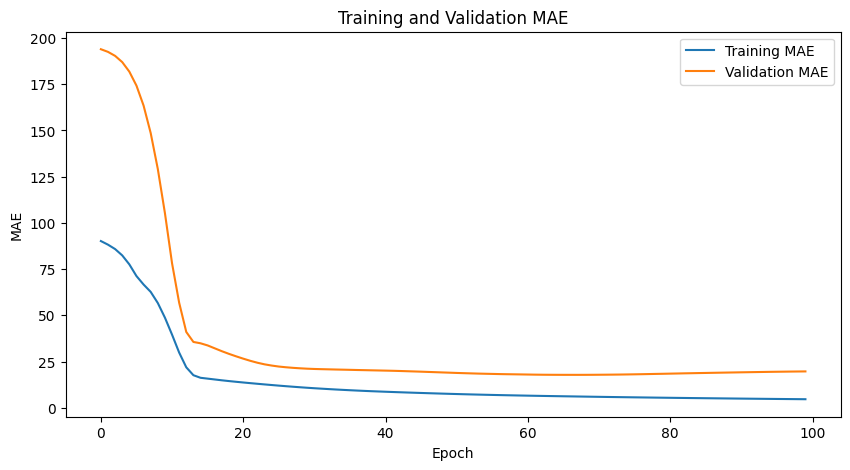

In [35]:



model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    X_train_scaled, Y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=False # since it is a time based series
)

model.evaluate(X_test_scaled, Y_test)
Y_pred = model.predict(X_test_scaled)

# visualizing the results - Loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# visualizing - MAE
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Feature analysis
So now I am interested in the weight of features in this model - is the CPI still dominating? by how much?

In [ ]:
first_layer = model.layers[0]
weights, biases = first_layer.get_weights()

feature_importance = np.mean(np.abs(weights), axis=1)
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": feature_importance
}).sort_values(by="importance", ascending=False)

print(importance_df)

importance_df.plot(kind="bar", x="feature", y="importance", figsize=(10,5))

In [ ]:
# inspect y (use your actual y_train/y_test variable names)
print("y_train stats:", Y_train.describe())
print("y_test  stats:", Y_test.describe())
print("y_train dtype:", Y_train.dtype)
print("y_test  dtype:", Y_test.dtype)

# values near zero?
print("y_train unique sample:", Y_train.unique()[:10])